In [1]:
import sys
sys.path.append('code/BalancingControl')

import two_stage_utils as tu
import inference as inf

torch threads 1
Running on device cpu


In [2]:
import torch
import pyro

import pyro.distributions as dist

import os
from scipy.io import loadmat
from scipy.stats import ttest_1samp, mannwhitneyu
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
import json
import gc
from statannotations.Annotator import Annotator

In [3]:
results_folder = "results"
inference_folder = os.path.join(results_folder, "inference")
model_comp_folder = os.path.join(results_folder, "model_comparison")

mask_file_name = "mask.txt"
processed_data_folder = os.path.join(results_folder, "processed_data")
mask_file = os.path.join(processed_data_folder, mask_file_name)

processed_data_folder = os.path.join(results_folder, "processed_data")

non_fit_fname = "non_fit_file.txt"
non_fit_file = os.path.join(model_comp_folder, non_fit_fname)

full_data_fname = "full_data.csv"
full_data_file = os.path.join(processed_data_folder, full_data_fname)

full_data_df = pd.read_csv(full_data_file)

n_agents = 188

In [4]:
trials =  201#number of trials
T = 3 #number of time steps in each trial
nb = 4 # number of bandits, ie second level rewards
ns = 3+nb #number of states
no = ns #number of observations
na = 2 #number of actions
npi = na**(T-1) #number of policies
nr = 2 #number of rewards
never_reward = ns-nb # states that dont generate rewards

# prob for invalid answer (e.g. no reply). Same frequency as in the real data
# prob for invalid answer (e.g. no reply). Same frequency as in the real data
with open(mask_file, "rb") as f:
    all_mask = pickle.load(f)
# simulations will be done with the same missing actions as in the data.
exp_mask = torch.tensor(all_mask).permute((1,0))
p_valid = exp_mask.sum()/(exp_mask.shape[0]*exp_mask.shape[1])
print(p_valid)

# make global parameter dict:
global_experiment_parameters = {"trials": trials, "T": T, "nb": nb, "ns": ns, "no": no, "na": na, "npi": npi, "nr": nr, "never_reward": never_reward, "p_invalid": p_valid, "mask": exp_mask}

tensor(0.9766)


/tmp/ipykernel_26654/1548601007.py:16: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  exp_mask = torch.tensor(all_mask).permute((1,0))


In [5]:
#generating probability of observations in each state / unity matrix
A = torch.eye(no)


#state transition generative probability (matrix)
B = torch.zeros((ns, ns, na))
b1 = 0.7
nb1 = 1.-b1
b2 = 0.7
nb2 = 1.-b2

B[:,:,0] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [ b1,  0,  0,  0,  0,  0,  0,],
                         [nb1,  0,  0,  0,  0,  0,  0,],
                         [  0,  1,  0,  1,  0,  0,  0,],
                         [  0,  0,  1,  0,  1,  0,  0,],
                         [  0,  0,  0,  0,  0,  1,  0,],
                         [  0,  0,  0,  0,  0,  0,  1,],])

B[:,:,1] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [nb2,  0,  0,  0,  0,  0,  0,],
                         [ b2,  0,  0,  0,  0,  0,  0,],
                         [  0,  0,  0,  1,  0,  0,  0,],
                         [  0,  0,  0,  0,  1,  0,  0,],
                         [  0,  1,  0,  0,  0,  1,  0,],
                         [  0,  0,  1,  0,  0,  0,  1,],])

# add to parameter dict
global_experiment_parameters["A"] = A
global_experiment_parameters["B"] = B

In [6]:
def convert_data_for_agent(full_data_df):

    mask = full_data_df.loc[(full_data_df["step_index"]==1)]
    mask_formatted = torch.stack([torch.from_numpy(mask.loc[mask["subject"]==i]["mask"].to_numpy()) for i in range(n_agents)])

    actions1 = full_data_df.loc[(full_data_df["step_index"]==1)]
    actions1_formatted = torch.stack([torch.from_numpy(actions1.loc[actions1["subject"]==i]["first_stage_actions"].to_numpy()) for i in range(n_agents)])

    actions2 = full_data_df.loc[(full_data_df["step_index"]==2)]
    actions2_formatted = torch.stack([torch.from_numpy(actions2.loc[actions2["subject"]==i]["second_stage_actions"].to_numpy()) for i in range(n_agents)])

    print("possible actions1", torch.unique(actions1_formatted[mask_formatted]))
    print("possible actions2", torch.unique(actions2_formatted[mask_formatted]))

    # write minus one into invalid regions (currently returns integer overflow below when converted to int)
    actions1_formatted = torch.where(mask_formatted, actions1_formatted, -1)
    actions2_formatted = torch.where(mask_formatted, actions2_formatted, -1)

    actions = torch.stack([actions1_formatted, actions2_formatted], dim=-1).permute((1,2,0))
    #print(actions.permute((0,2,1))[mask_formatted])
    # agent counts from zero:
    actions = actions-1.

    states1 = full_data_df.loc[(full_data_df["step_index"]==1)]
    # agent counts from zero, hence -1 at the end:
    states1_formatted = torch.stack([torch.from_numpy(states1.loc[states1["subject"]==i]["first_stage_states"].to_numpy()) for i in range(n_agents)]) - 1
     
    states2 = full_data_df.loc[(full_data_df["step_index"]==2)]
    # agent counts from zero, hence -1 at the end:
    states2_formatted = torch.stack([torch.from_numpy(states2.loc[states2["subject"]==i]["second_stage_states"].to_numpy()) for i in range(n_agents)]) - 1

    # write minus one into invalid regions (currently returns integer overflow below when converted to int)
    states1_formatted = torch.where(mask_formatted, states1_formatted, -1)
    states2_formatted = torch.where(mask_formatted, states2_formatted, -1)
    # create third time step states:
    states3_formatted = states2_formatted+2 + (actions2_formatted-1)*2
    states3_formatted = torch.where(mask_formatted, states3_formatted, -1)


    print("possible states1", torch.unique(states1_formatted[mask_formatted]))
    print("possible states2", torch.unique(states2_formatted[mask_formatted]))
    print("possible states3", torch.unique(states3_formatted[mask_formatted]))

    states = torch.stack([states1_formatted, states2_formatted, states3_formatted], dim=-1).permute((1,2,0))

    # agent views r=2 as "no reward", may instead give negative reward as in Otto et al:
    rewards1_formatted = torch.zeros_like(states1_formatted) #+ 2

    rewards2_formatted = rewards1_formatted

    # create third time step rewards = second stage rewards:
    rewards3 = full_data_df.loc[(full_data_df["step_index"]==2)]
    rewards3_formatted = torch.stack([torch.from_numpy(rewards3.loc[rewards3["subject"]==i]["second_stage_rewards"].to_numpy()) for i in range(n_agents)])

    print("possible rewards1", torch.unique(rewards1_formatted[mask_formatted]))
    print("possible rewards2", torch.unique(rewards2_formatted[mask_formatted]))
    print("possible rewards3", torch.unique(rewards3_formatted[mask_formatted]))

    # write minus one into invalid regions (currently returns integer overflow below when converted to int)
    rewards1_formatted = torch.where(mask_formatted, rewards1_formatted, -1)
    rewards2_formatted = torch.where(mask_formatted, rewards2_formatted, -1)
    rewards3_formatted = torch.where(mask_formatted, rewards3_formatted, -1)

    rewards = torch.stack([rewards1_formatted, rewards2_formatted, rewards3_formatted], dim=-1).permute((1,2,0))


    data_dict = {"observations": states.long(), "rewards": rewards.long(), "actions": actions.long(), "valid": mask_formatted.permute((1,0))}

    return data_dict

data = convert_data_for_agent(full_data_df)

possible actions1 tensor([1., 2.], dtype=torch.float64)
possible actions2 tensor([1., 2.], dtype=torch.float64)
possible states1 tensor([0.], dtype=torch.float64)
possible states2 tensor([1., 2.], dtype=torch.float64)
possible states3 tensor([3., 4., 5., 6.], dtype=torch.float64)
possible rewards1 tensor([0.], dtype=torch.float64)
possible rewards2 tensor([0.], dtype=torch.float64)
possible rewards3 tensor([0., 1.], dtype=torch.float64)


In [7]:
def load_BCC_results(infer_h, base_dir, global_experiment_parameters, valid, fname_base, num_steps, data, param_names):    

    # set up agent
    bayes_agent = tu.set_up_Bayesian_inference_agent(n_agents, infer_h, base_dir, global_experiment_parameters, valid, remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = False

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_df = tu.load_samples(base_dir, fname_str) 

    return mean_df, sample_df, locs_df

In [8]:
def load_MFMB_results(use_orig, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, valid, fname_base, num_steps, data, param_names):    

    # set up agent
    mfmb_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, valid, remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = False

    # set up inference
    inferrer = inf.GeneralGroupInference(mfmb_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_df = tu.load_samples(base_dir, fname_str) 

    return mean_df, sample_df, locs_df

In [9]:
def calculate_log_likelihood(data, agent, locs_df, npars, trials, T):

    # question: what do with nan trials? If I ignore them, they will decrease the likelihood and make subject seem to fit better. If I make them uniform, itll decrease by a lot?
    # this is the likelihood of the average parameter

    n_agents = data["actions"].shape[-1]
    log_like = torch.zeros(n_agents)
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(locs_df[locs_df["subject"]==i]["locs"+str(k)].mean())
        locs_list.append(torch.tensor(locs_subs).float())

    locs = torch.stack(locs_list, dim=-1)
    
    assert(locs.shape[0]==n_agents)

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)[0]

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.5]))

                log_like += torch.log(masked_probs)

    return log_like
    

In [10]:
def calculate_BIC(data, agent, locs_df, npars, trials, T):

    # use bic to circumvent the number of trials problem

    n_agents = data["actions"].shape[-1]
    BIC = torch.zeros(n_agents)
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(locs_df[locs_df["subject"]==i]["locs"+str(k)].mean())
        locs_list.append(torch.tensor(locs_subs).float())

    locs = torch.stack(locs_list, dim=-1)
    
    assert(locs.shape[0]==n_agents)

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)[0]

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor(0.5))

                print(masked_probs.shape)

                BIC -= 2*torch.log(masked_probs)

    # question: is it noraml that the first term of the BIC (k*ln(n)) is much smaller than the second (-2*ln(L))?
    BIC += npars*torch.log(data["valid"].sum(axis=0))

    return BIC
    

In [11]:
def calculate_lppd(data, agent, locs_df, npars, trials, T, max_samples=-1):

    # question: what do with nan trials? If I ignore them, they will decrease the likelihood and make subject seem to fit better. If I make them uniform, itll decrease by a lot?
    # Eqs (4,5) from here:
    # http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf
    # this is the average likelihood

    n_agents = data["actions"].shape[-1]
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(torch.tensor(locs_df[locs_df["subject"]==i]["locs"+str(k)].values[:max_samples]).float())
        locs_list.append(torch.stack(locs_subs, dim=-1))

    locs = torch.stack(locs_list, dim=-1)

    n_samples = locs.shape[0]

    likelihoods = []

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                #print("probs", probs.shape)
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.5]))
                #print("masked probs", masked_probs.shape)

                likelihoods.append(masked_probs)

                #print(tau,t)

    mean_like = torch.stack(likelihoods, dim=0)
    # print("mean like stacked", mean_like.shape)
    # print(mean_like)

    mean_like = mean_like.sum(dim=-2) / n_samples
    # print("mean like summed", mean_like.shape)
    # print(mean_like)

    mean_log_like = torch.log(mean_like).sum(dim=0)

    #print(mean_log_like)
    # print("mean log like", mean_log_like.shape)
    # print(mean_log_like)

    return mean_log_like.clone().detach()
    

In [12]:
def calculate_waic(data, agent, locs_df, npars, trials, T, max_samples=-1):

    # question: what do with nan trials? If I ignore them, they will decrease the likelihood and make subject seem to fit better. If I make them uniform, itll decrease by a lot?
    # Eqs (12,13) from here:
    # http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf
    # this is the average WAIC
    # are the larger number of params handled correctly?

    n_agents = data["actions"].shape[-1]
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(torch.tensor(locs_df[locs_df["subject"]==i]["locs"+str(k)].values[:max_samples]).float())
        locs_list.append(torch.stack(locs_subs, dim=-1))

    locs = torch.stack(locs_list, dim=-1)

    n_samples = locs.shape[0]

    likelihoods = []

    agent.reset(locs)

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:

                probs = agent.perception.posterior_actions[-1]
                #print("probs", probs.shape)
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]*data["valid"][tau].long()

                one_hot_responses = torch.nn.functional.one_hot(curr_response, num_classes=2).permute((1,0))[:,None,:].float()

                likes = (probs * one_hot_responses).sum(dim=0)

                masked_probs = torch.where(data["valid"][tau], likes, torch.tensor([0.5]))
                #print("masked probs", masked_probs.shape)

                likelihoods.append(masked_probs)

                #print(tau,t)



    mean_like = torch.stack(likelihoods, dim=0)
    # print("mean like stacked", mean_like.shape)
    # print(mean_like)

    mean_like_samples = mean_like.sum(dim=-2) / n_samples
    # print("mean like summed", mean_like.shape)
    # print(mean_like)

    lppd = torch.log(mean_like_samples).sum(dim=0)
    # print("mean log like", mean_log_like.shape)
    # print(mean_log_like)

    mean_log_like_samples = torch.log(mean_like.sum(dim=-2)) / n_samples

    V_s = ((torch.log(mean_like) - mean_log_like_samples[:,None,:])**2).sum(dim=-2) / (n_samples-1)

    p_waic = V_s.sum(dim=0)

    ellp_waic = lppd - p_waic

    # text says it needs to be -2 * eq 13.
    # minus is required to make lower better, and the 2 converts it to variance scale

    return ellp_waic.clone().detach()
    

In [13]:
def predictive_accuracy_mean_param(data, agent, locs_df, npars, trials, T):

    n_agents = data["actions"].shape[-1]

    predicted_accuracy = torch.zeros(n_agents)
    
    locs_list = []
    for k in range(npars):
        locs_subs = []
        for i in range(n_agents):
            locs_subs.append(locs_df[locs_df["subject"]==i]["locs"+str(k)].mean())
        locs_list.append(torch.tensor(locs_subs).float())

    locs = torch.stack(locs_list, dim=-1)
    
    assert(locs.shape[0]==n_agents)

    agent.reset(locs)

    num_valid_responses = torch.zeros(data["actions"].shape[-1])

    for tau in pyro.markov(range(trials)):
        for t in range(T):

            if t==0:
                prev_response = None
                context = None
            else:
                prev_response = data["actions"][tau, t-1]
                context = None

            observation = data["observations"][tau, t]

            reward = data["rewards"][tau, t]

            agent.update_beliefs(tau, t, observation, reward, prev_response, context)

            if t < T-1:
                #print(tau,t)

                probs = agent.perception.posterior_actions[-1]
                if torch.any(torch.isnan(probs)):
                    print(probs)
                    #print(param_dict)
                    print(tau,t)

                curr_response = data["actions"][tau, t]#*data["valid"][tau].long()
                #print(curr_response)

                predicted_response = torch.argmax(probs, dim=0)[0]

                #print(probs)

                #print(predicted_response)

                correct_response_predicted = (curr_response == predicted_response).int()

                #print(correct_response_predicted)

                predicted_accuracy += correct_response_predicted

                num_valid_responses += data["valid"][tau]

                #print(num_valid_responses)


    corrected_predicted_accuracy = predicted_accuracy / num_valid_responses

    return corrected_predicted_accuracy

In [14]:
def calculate_exceedance_prob(measure, n_exc_samples=500):
    
    p_model = torch.nn.functional.softmax(measure, dim=-1)

    print("p model mean according to measure", p_model.mean(dim=0))

    dirichlet_counts = p_model.sum(dim=0)

    model_prob_dirichlet = dist.Dirichlet(dirichlet_counts)

    n_exc_samples = 500

    dir_samples = model_prob_dirichlet.sample(sample_shape=torch.tensor([n_exc_samples]))

    avg_best_model = dir_samples.mean(dim=0).argmax()

    best_model = dir_samples.argmax(dim=1)

    exc_prob = (best_model == avg_best_model).sum()/n_exc_samples

    print("best model:", avg_best_model, "exceedance prob", exc_prob)

    significant_best_model = ttest_1samp(dir_samples[:,avg_best_model], 1./measure.shape[-1], alternative="greater")

    print("is significantly different from uniform?", significant_best_model)

    return exc_prob, avg_best_model

BCC_3param_inference_
analyzing 188 data sets


/home/sarah/src/BayesianTwoStageTaskAnalysis/code/BalancingControl/perception.py:103: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1699116133598/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  self.big_trans_matrix = ar.stack([ar.stack([generative_model_states[:,:,policies[pi,t]] for pi in range(self.npi)]) for t in range(self.T-1)]).T.to(device)


<Figure size 640x480 with 0 Axes>

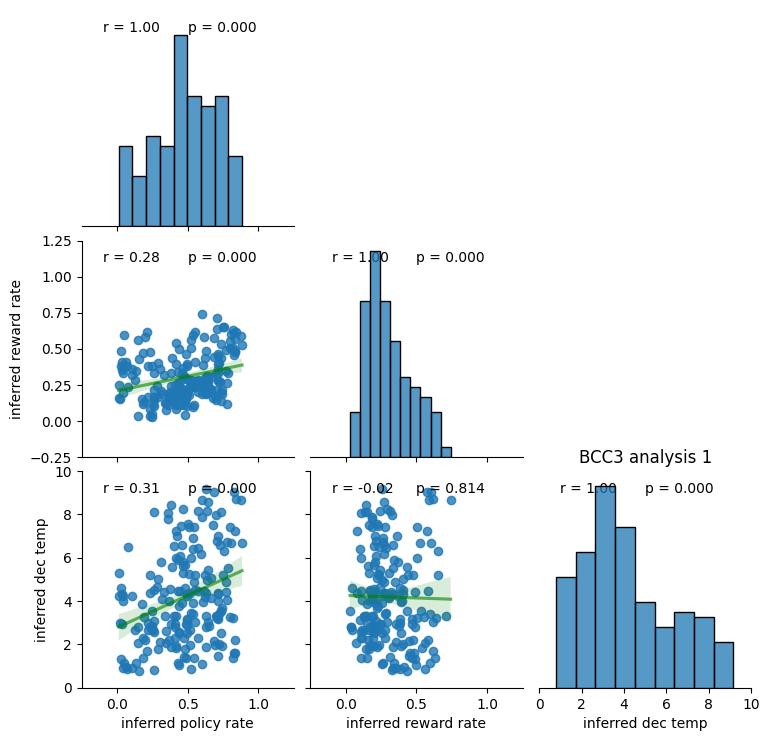

This is inference for the twostage task using the Bayesian prior-based contextual control model(BCC_3param) with 188 agents.
The settings are: infer h False


In [15]:
# BCC3 analysis 1

infer_h = False

prefix = "BCC_"
param_names = ["policy rate", "reward rate", "dec temp", "habitual tendency"]
model_name = "Bayesian prior-based contextual control model"

if infer_h:
    n_pars = 4
    h_str = "4param"
else:
    n_pars = 3
    h_str = "3param"
    param_names = param_names[:-1]

BCC3_param_names = param_names

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = prefix+h_str+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

BCC3_1_mean_df, BCC3_1_sample_df, BCC3_locs_df = load_BCC_results(infer_h, base_dir, global_experiment_parameters, exp_mask, fname_base, num_steps, data, param_names)

param_ranges = [[0,1], [0,1], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC3_1_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[2,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("BCC3 analysis 1")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+prefix+h_str+")"+" with "+str(n_agents)+" agents.")
print("The settings are: infer h", infer_h)

In [16]:
# calculate agent log likelihood using mean params

BCC3_agent = tu.set_up_Bayesian_inference_agent(n_agents, infer_h, base_dir, global_experiment_parameters, data["valid"], remove_old=False)

BCC3_params = torch.stack([torch.tensor(BCC3_1_mean_df["inferred "+name]) for name in param_names], dim=-1)


BCC3_log_like = -calculate_log_likelihood(data, BCC3_agent, BCC3_locs_df, len(BCC3_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

BCC3_BIC = calculate_BIC(data, BCC3_agent, BCC3_locs_df, len(BCC3_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

BCC3_lppd = -calculate_lppd(data, BCC3_agent, BCC3_locs_df, len(BCC3_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC3_WAIC = -calculate_waic(data, BCC3_agent, BCC3_locs_df, len(BCC3_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

measures_df = pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC3_log_like, "type": ["log likelihood"]*n_agents, "model": ["BCC3"]*n_agents})
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC3_lppd, "type": ["lppd"]*n_agents, "model": ["BCC3"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC3_BIC, "type": ["BIC"]*n_agents, "model": ["BCC3"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC3_WAIC, "type": ["WAIC"]*n_agents, "model": ["BCC3"]*n_agents})])

print("BCC3 log like", BCC3_log_like.mean())

print("BCC3 BIC", BCC3_BIC.mean())

print("BCC3 lppd", BCC3_lppd.mean())

gc.collect()

torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size

2263

BCC_4param_inference_
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

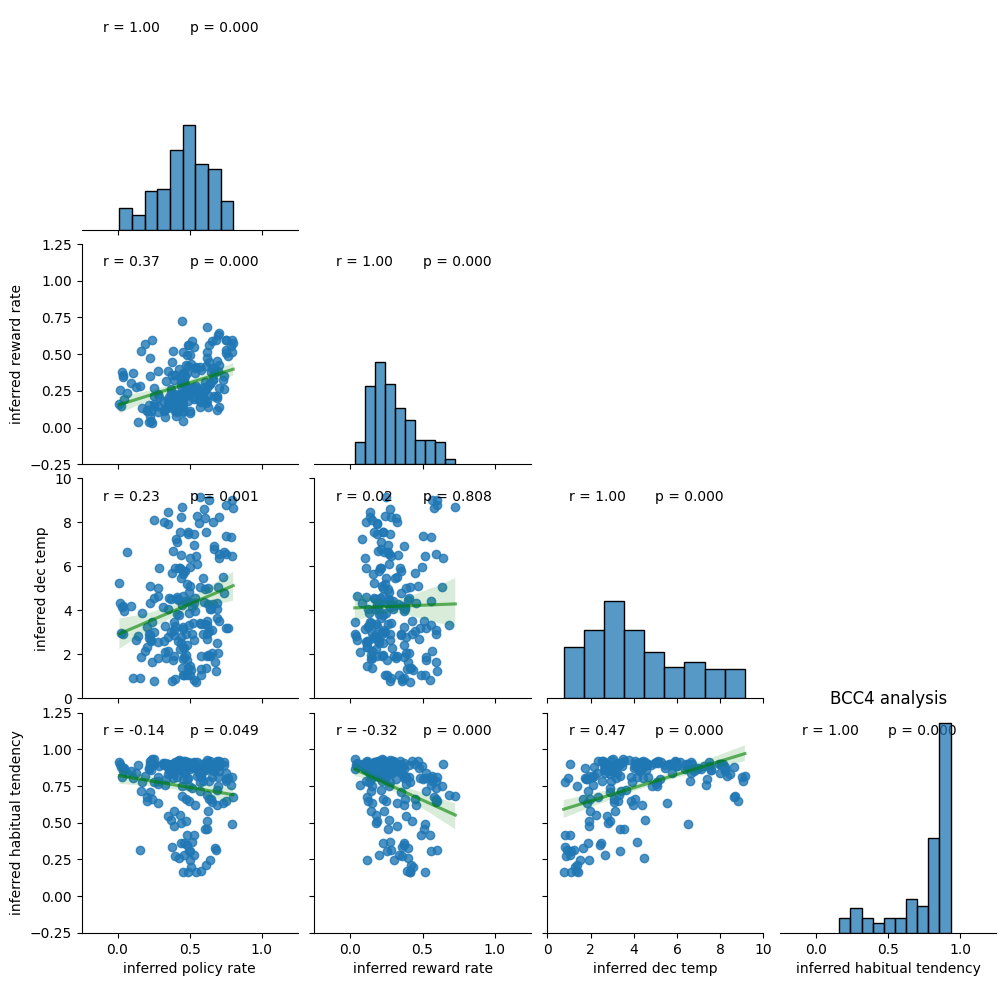

This is inference for the twostage task using the Bayesian prior-based contextual control model(BCC_4param) with 188 agents.
The settings are: infer h True


In [17]:
# BCC4

infer_h = True

prefix = "BCC_"
param_names = ["policy rate", "reward rate", "dec temp", "habitual tendency"]
model_name = "Bayesian prior-based contextual control model"

if infer_h:
    n_pars = 4
    h_str = "4param"
else:
    n_pars = 3
    h_str = "3param"
    param_names = param_names[:-1]

BCC4_param_names = param_names

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = prefix+h_str+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

BCC4_mean_df, BCC4_sample_df, BCC4_locs_df = load_BCC_results(infer_h, base_dir, global_experiment_parameters, exp_mask, fname_base, num_steps, data, param_names)

BCC_param_ranges = [[0,1], [0,1], [0,max_dt], [0,1]]
BCC_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10], [-0.25,1.25]]
BCC_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
plt.title("BCC4 analysis")
for p, p_range in enumerate(BCC_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+prefix+h_str+")"+" with "+str(n_agents)+" agents.")
print("The settings are: infer h", infer_h)

In [18]:
# calculate agent log likelihood using mean params

BCC4_agent = tu.set_up_Bayesian_inference_agent(n_agents, infer_h, base_dir, global_experiment_parameters, data["valid"], remove_old=False)

BCC4_params = torch.stack([torch.tensor(BCC4_mean_df["inferred "+name]) for name in param_names], dim=-1)
print(BCC4_sample_df.keys())

BCC4_log_like = -calculate_log_likelihood(data, BCC4_agent, BCC4_locs_df, len(BCC4_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

BCC4_BIC = calculate_BIC(data, BCC4_agent, BCC4_locs_df, len(BCC4_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

BCC4_lppd = -calculate_lppd(data, BCC4_agent, BCC4_locs_df, len(BCC4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

BCC4_WAIC = -calculate_waic(data, BCC4_agent, BCC4_locs_df, len(BCC4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC4_log_like, "type": ["log likelihood"]*n_agents, "model": ["BCC4"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC4_lppd, "type": ["lppd"]*n_agents, "model": ["BCC4"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC4_BIC, "type": ["BIC"]*n_agents, "model": ["BCC4"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": BCC4_WAIC, "type": ["WAIC"]*n_agents, "model": ["BCC4"]*n_agents})])

print("BCC4 log like", BCC4_log_like.mean())

print("BCC4 BIC", BCC4_BIC.mean())

print("BCC4 lppd", BCC4_lppd.mean())

gc.collect()

Index(['Unnamed: 0', 'policy rate', 'reward rate', 'dec temp',
       'habitual tendency', 'subject'],
      dtype='object')
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size(

1071

In [ ]:
print(measures_df)

     subject     measure            type model
0          0  178.329636  log likelihood  BCC3
1          1  172.858826  log likelihood  BCC3
2          2  255.819977  log likelihood  BCC3
3          3  193.038757  log likelihood  BCC3
4          4  230.353271  log likelihood  BCC3
..       ...         ...             ...   ...
183      183  519.884766            WAIC  BCC4
184      184  444.584717            WAIC  BCC4
185      185  352.047607            WAIC  BCC4
186      186  429.985382            WAIC  BCC4
187      187  509.210052            WAIC  BCC4

[1504 rows x 4 columns]


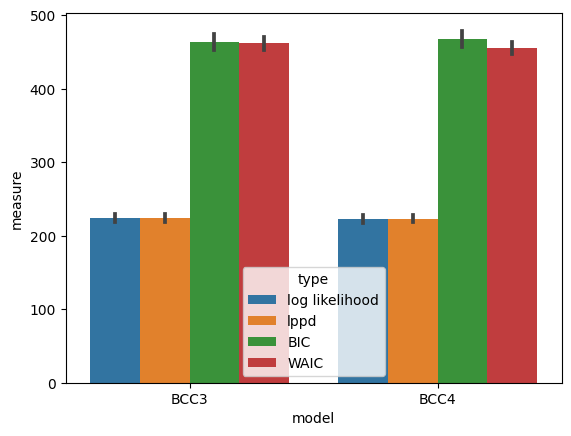

In [20]:
# plot differences in fit for BCC model

plt.figure()
sns.barplot(data=measures_df, x="model", y="measure", hue="type")
plt.show()

mbmf_4param_inference_
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

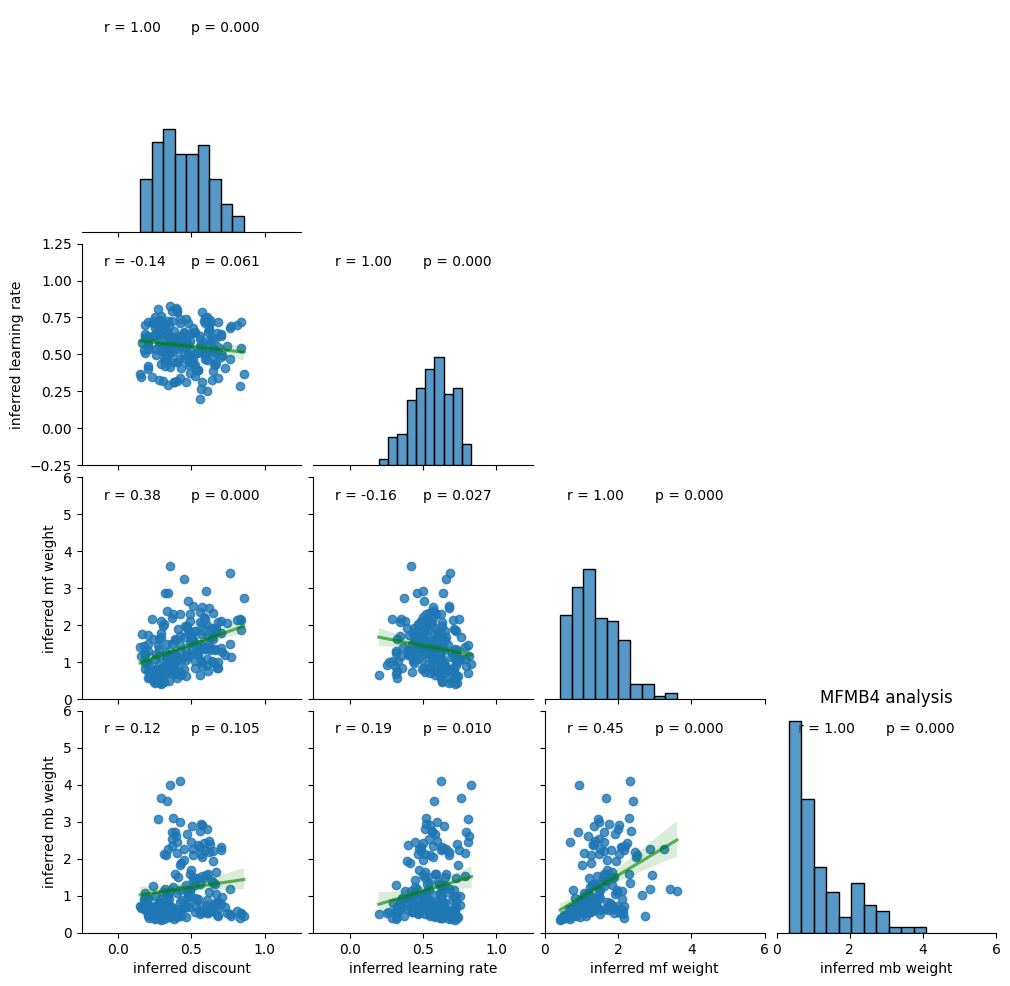

This is inference for the twostage task using the two beta mbmf model(mbmf_4param) with 188 agents.
The settings are: use p False


In [21]:
# MFMB4 analysis

# set parameters and their names

use_orig = False

use_p = False
restrict_alpha = False
max_dt = 6

if use_orig:
    prefix = "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight", "repetition"]
    model_name = "original original w and beta model"
else:
    prefix = "mbmf_"
    param_names = ["discount", "learning rate", "mf weight", "mb weight", "repetition"]
    model_name = "two beta mbmf model"

if use_p:
    n_pars = 5
    p_str = "5param"
else:
    n_pars = 4
    p_str = "4param"
    param_names = param_names[:-1]

MFMB4_param_names = param_names
    
if restrict_alpha:
    restr_str = "_resticted"
    min_alpha = 0.1
else:
    restr_str = ""
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
agent_type = prefix+p_str+restr_str

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = agent_type+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

MFMB4_mean_df, MFMB4_sample_df, MFMB4_locs_df = load_MFMB_results(use_orig, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, data["valid"], fname_base, num_steps, data, param_names)

param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=MFMB4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB4 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+agent_type+")"+" with "+str(n_agents)+" agents.")
print("The settings are: use p", use_p)

In [22]:
# calculate agent log likelihood using mean params

MFMB4_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, data["valid"], remove_old=False)
MFMB4_params = torch.stack([torch.tensor(MFMB4_mean_df["inferred "+name]) for name in param_names], dim=-1)


MFMB4_log_like = -calculate_log_likelihood(data, MFMB4_agent, MFMB4_locs_df, len(MFMB4_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

MFMB4_BIC = calculate_BIC(data, MFMB4_agent, MFMB4_locs_df, len(MFMB4_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

MFMB4_lppd = -calculate_lppd(data, MFMB4_agent, MFMB4_locs_df, len(MFMB4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB4_WAIC = -calculate_waic(data, MFMB4_agent, MFMB4_locs_df, len(MFMB4_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB4_log_like, "type": ["log likelihood"]*n_agents, "model": ["MFMB4"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB4_lppd, "type": ["lppd"]*n_agents, "model": ["MFMB4"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB4_BIC, "type": ["BIC"]*n_agents, "model": ["MFMB4"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB4_WAIC, "type": ["WAIC"]*n_agents, "model": ["MFMB4"]*n_agents})])

print("MFMB4 log like", MFMB4_log_like.mean())

print("MFMB4 BIC", MFMB4_BIC.mean())

gc.collect()

torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size

52220

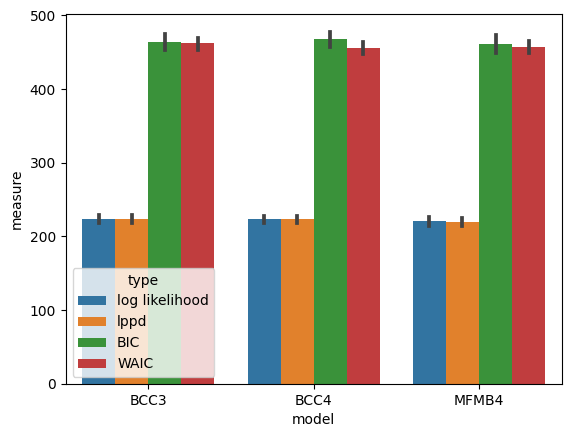

In [23]:
plt.figure()
sns.barplot(data=measures_df, x="model", y="measure", hue="type")
plt.show()

mbmf_5param_inference_
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

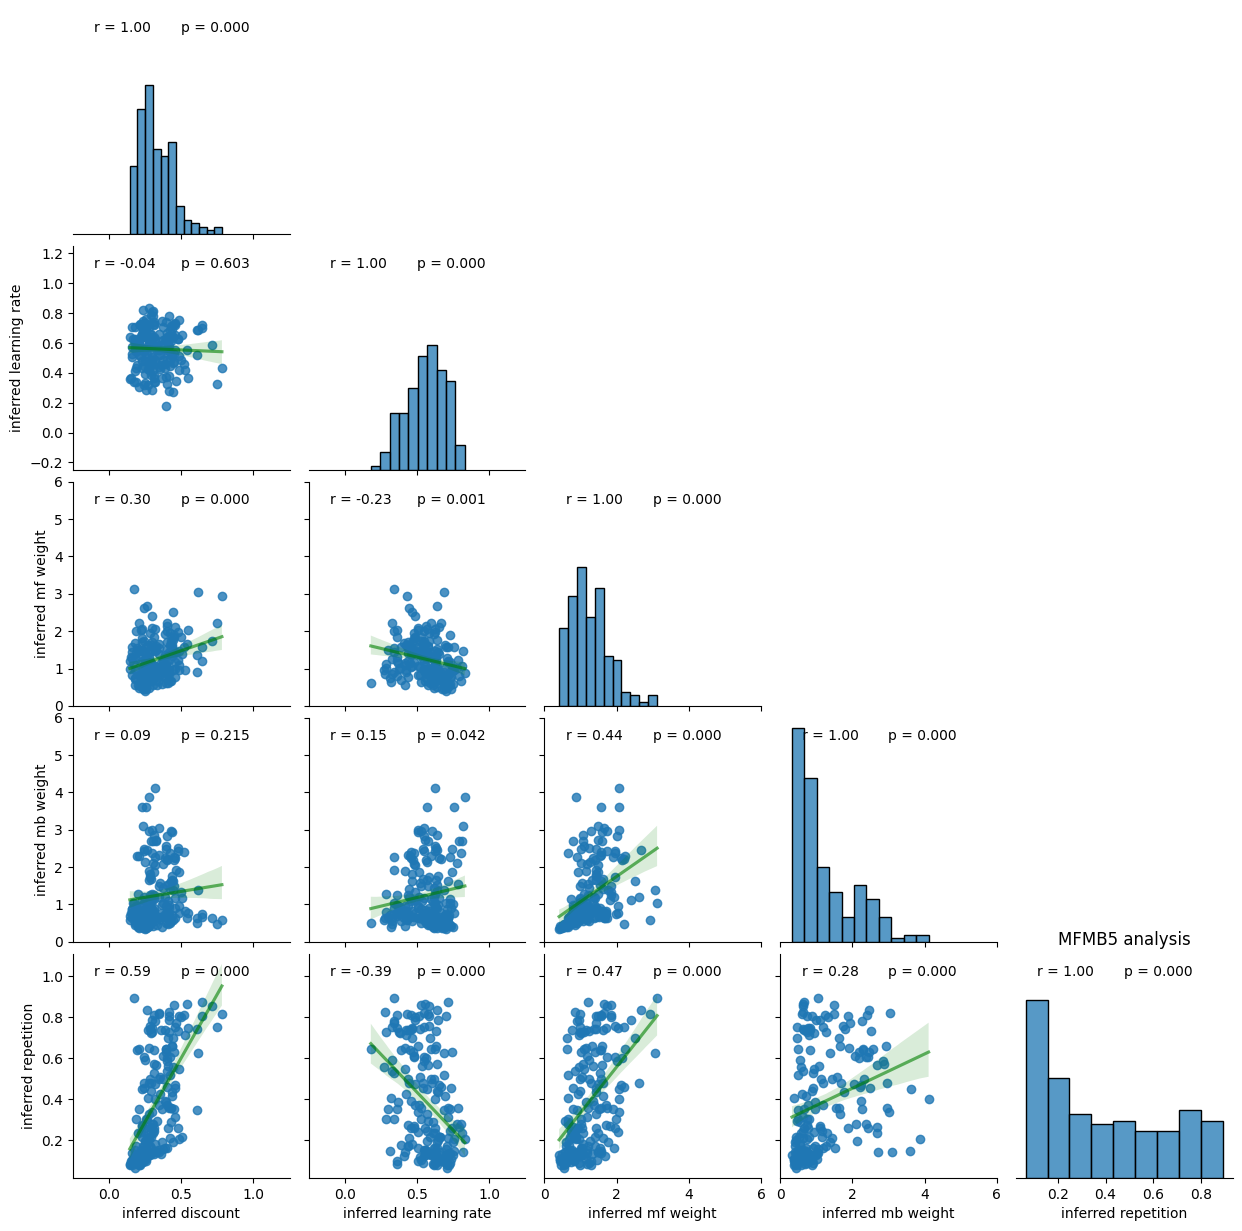

This is inference for the twostage task using the two beta mbmf model(mbmf_5param) with 188 agents.
The settings are: use p True


In [24]:
# MFMB5 analysis

# set parameters and their names

use_orig = False

use_p = True
restrict_alpha = False
max_dt = 6

if use_orig:
    prefix = "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight", "repetition"]
    model_name = "original original w and beta model"
else:
    prefix = "mbmf_"
    param_names = ["discount", "learning rate", "mf weight", "mb weight", "repetition"]
    model_name = "two beta mbmf model"

if use_p:
    n_pars = 5
    p_str = "5param"
else:
    n_pars = 4
    p_str = "4param"
    param_names = param_names[:-1]

MFMB5_param_names = param_names
    
if restrict_alpha:
    restr_str = "_resticted"
    min_alpha = 0.1
else:
    restr_str = ""
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
agent_type = prefix+p_str+restr_str

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
fname_base = agent_type+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

MFMB5_mean_df, MFMB5_sample_df, MFMB5_locs_df = load_MFMB_results(use_orig, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, data["valid"], fname_base, num_steps, data, param_names)

MFMB_param_ranges = [[0,1], [0,1], [0,max_dt], [0,max_dt]]
MFMB_param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,max_dt], [0,max_dt]]
MFMB_param_names = param_names.copy()

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=MFMB5_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(MFMB_param_plot_ranges):
    f.axes[3,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+agent_type+")"+" with "+str(n_agents)+" agents.")
print("The settings are: use p", use_p)

In [25]:
# calculate agent log likelihood using mean params

MFMB5_agent = tu.set_up_mbmf_inference_agent(n_agents, use_orig, use_p, restrict_alpha, max_dt, min_alpha, base_dir, global_experiment_parameters, data["valid"], remove_old=False)
MFMB5_params = torch.stack([torch.tensor(MFMB5_mean_df["inferred "+name]) for name in param_names], dim=-1)


MFMB5_log_like = -calculate_log_likelihood(data, MFMB5_agent, MFMB5_locs_df, len(MFMB5_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

MFMB5_BIC = calculate_BIC(data, MFMB5_agent, MFMB5_locs_df, len(MFMB5_param_names), global_experiment_parameters["trials"], global_experiment_parameters["T"])

MFMB5_lppd = -calculate_lppd(data, MFMB5_agent, MFMB5_locs_df, len(MFMB5_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

MFMB5_WAIC = -calculate_waic(data, MFMB5_agent, MFMB5_locs_df, len(MFMB5_param_names), 
                            global_experiment_parameters["trials"], global_experiment_parameters["T"], max_samples=50)

measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB5_log_like, "type": ["log likelihood"]*n_agents, "model": ["MFMB5"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB5_lppd, "type": ["lppd"]*n_agents, "model": ["MFMB5"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB5_BIC, "type": ["BIC"]*n_agents, "model": ["MFMB5"]*n_agents})])
measures_df = pd.concat([measures_df, pd.DataFrame({"subject": list(range(n_agents)), "measure": MFMB5_WAIC, "type": ["WAIC"]*n_agents, "model": ["MFMB5"]*n_agents})])

print("MFMB5 log like", MFMB5_log_like.mean())

print("MFMB5 BIC", MFMB5_BIC.mean())

gc.collect()

torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size([188])
torch.Size

57823

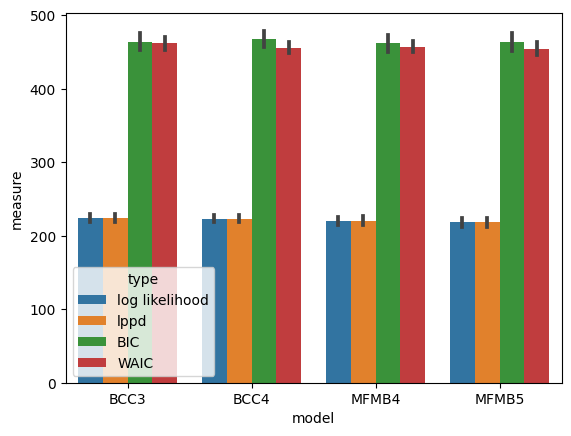

In [26]:
plt.figure()
sns.barplot(data=measures_df, x="model", y="measure", hue="type")
plt.savefig(os.path.join(model_comp_folder, "model_comparison.svg"))
plt.savefig(os.path.join(model_comp_folder, "model_comparison.png"))
plt.show()

In [27]:
with open(non_fit_file, "r") as f:
    all_didnt_fit = json.load(f)

did_fit = torch.ones(n_agents).bool()
did_fit[all_didnt_fit] = False

print(did_fit.sum())

tensor(165)


In [28]:
all_total_log_likes = torch.stack([BCC3_log_like, BCC4_log_like, MFMB4_log_like, MFMB5_log_like], dim=-1)

winning_model = all_total_log_likes.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

all_log_likes_exc_prob, all_log_likes_avg_best_model = calculate_exceedance_prob(-all_total_log_likes)

BCC3 wins tensor(21)
BCC4 wins tensor(53)
MFMB4 wins tensor(28)
MFMB5 wins tensor(86)
p model mean according to measure tensor([0.1310, 0.2563, 0.1553, 0.4574])
best model: tensor(3) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=127.2368678860559, pvalue=0.0, df=499)


In [29]:
all_total_log_likes_did_fit = torch.stack([BCC3_log_like, BCC4_log_like, MFMB4_log_like, MFMB5_log_like], dim=-1)[did_fit]

winning_model = all_total_log_likes_did_fit.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

all_log_likes_exc_prob_did_fit, all_log_likes_avg_best_model_did_fit = calculate_exceedance_prob(-all_total_log_likes_did_fit)

BCC3 wins tensor(21)
BCC4 wins tensor(35)
MFMB4 wins tensor(25)
MFMB5 wins tensor(84)
p model mean according to measure tensor([0.1393, 0.2081, 0.1516, 0.5009])
best model: tensor(3) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=146.2409704249141, pvalue=0.0, df=499)


In [30]:
BCC4_MFMB4_total_log_likes = torch.stack([BCC4_log_like, MFMB4_log_like], dim=-1)

winning_model = BCC4_MFMB4_total_log_likes.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

BCC4_MFMB4_log_likes_exc_prob, BCC4_MFMB4_total_log_likes_avg_best_model = calculate_exceedance_prob(-BCC4_MFMB4_total_log_likes)

BCC4 wins tensor(84)
MFMB4 wins tensor(104)
p model mean according to measure tensor([0.4321, 0.5679])
best model: tensor(1) exceedance prob tensor(0.9580)
is significantly different from uniform? TtestResult(statistic=41.09533692524315, pvalue=1.4140429214644793e-162, df=499)


In [31]:
BCC4_MFMB4_total_log_likes_did_fit = torch.stack([BCC4_log_like, MFMB4_log_like], dim=-1)[did_fit]

winning_model = BCC4_MFMB4_total_log_likes_did_fit.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

BCC4_MFMB4_log_likes_exc_prob_did_fit, BCC4_MFMB4_total_log_likes_avg_best_model_did_fit = calculate_exceedance_prob(-BCC4_MFMB4_total_log_likes_did_fit)

BCC4 wins tensor(65)
MFMB4 wins tensor(100)
p model mean according to measure tensor([0.3904, 0.6096])
best model: tensor(1) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=65.60277362469942, pvalue=8.323155584092821e-248, df=499)


In [32]:
BCC4_MFMB5_total_log_likes = torch.stack([BCC4_log_like, MFMB5_log_like], dim=-1)

winning_model = BCC4_MFMB5_total_log_likes.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB5 wins", (winning_model==1).sum())

BCC4_MFMB5_log_likes_exc_prob, BCC4_MFMB5_total_log_likes_avg_best_model = calculate_exceedance_prob(-BCC4_MFMB5_total_log_likes)

BCC4 wins tensor(76)
MFMB5 wins tensor(112)
p model mean according to measure tensor([0.3972, 0.6028])
best model: tensor(1) exceedance prob tensor(0.9980)
is significantly different from uniform? TtestResult(statistic=67.55088769462176, pvalue=1.6564337647887142e-253, df=499)


In [33]:
BCC4_MFMB5_total_log_likes_did_fit = torch.stack([BCC4_log_like, MFMB5_log_like], dim=-1)[did_fit]

winning_model = BCC4_MFMB5_total_log_likes_did_fit.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

BCC4_MFMB5_log_likes_exc_prob_did_fit, BCC4_MFMB5_total_log_likes_avg_best_model_did_fit = calculate_exceedance_prob(-BCC4_MFMB5_total_log_likes_did_fit)

BCC4 wins tensor(58)
MFMB4 wins tensor(107)
p model mean according to measure tensor([0.3472, 0.6528])
best model: tensor(1) exceedance prob tensor(1.)
is significantly different from uniform? TtestResult(statistic=95.0684374696135, pvalue=3.75e-322, df=499)


In [34]:
BCC4_MFMB4_MFMB5_total_log_likes = torch.stack([BCC4_log_like, MFMB4_log_like, MFMB5_log_like], dim=-1)

winning_model = BCC4_MFMB4_MFMB5_total_log_likes.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())
print("MFMB5 wins", (winning_model==2).sum())

BCC4_MFMB4_MFMB5_log_likes_exc_prob, BCC4_MFMB4_MFMB5_total_log_likes_avg_best_model = calculate_exceedance_prob(-BCC4_MFMB4_MFMB5_total_log_likes)

BCC4 wins tensor(74)
MFMB4 wins tensor(28)
MFMB5 wins tensor(86)
p model mean according to measure tensor([0.3640, 0.1637, 0.4724])
best model: tensor(2) exceedance prob tensor(0.9400)
is significantly different from uniform? TtestResult(statistic=86.57327185738845, pvalue=5.0459503662699495e-303, df=499)


In [35]:
BCC4_MFMB4_MFMB5_total_log_likes_did_fit = torch.stack([BCC4_log_like, MFMB4_log_like, MFMB5_log_like], dim=-1)[did_fit]

winning_model = BCC4_MFMB4_MFMB5_total_log_likes_did_fit.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())
print("MFMB5 wins", (winning_model==2).sum())

BCC4_MFMB4_MFMB5_log_likes_exc_prob_did_fit, BCC4_MFMB4_MFMB5_total_log_likes_avg_best_model_did_fit = calculate_exceedance_prob(-BCC4_MFMB4_MFMB5_total_log_likes_did_fit)

print((winning_model==0).sum()/n_agents)

BCC4 wins tensor(56)
MFMB4 wins tensor(25)
MFMB5 wins tensor(84)
p model mean according to measure tensor([0.3240, 0.1592, 0.5168])
best model: tensor(2) exceedance prob tensor(0.9980)
is significantly different from uniform? TtestResult(statistic=105.01579309581084, pvalue=0.0, df=499)
tensor(0.2979)


In [36]:
all_total_WAICs = torch.stack([BCC3_WAIC, BCC4_WAIC, MFMB4_WAIC, MFMB5_WAIC], dim=-1)

winning_model = all_total_WAICs.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

p_model = torch.nn.functional.softmax(-2*all_total_WAICs, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*all_total_WAICs.sum(dim=0), dim=-1)

print(p_model_total)

all_WAICs_exc_prob, all_WAICs_avg_best_model = calculate_exceedance_prob(-2*all_total_WAICs)

BCC3 wins tensor(16)
BCC4 wins tensor(81)
MFMB4 wins tensor(41)
MFMB5 wins tensor(50)
torch.Size([188, 4])
tensor([0.0912, 0.4237, 0.2106, 0.2746])
tensor([0., 0., 0., 1.])
p model mean according to measure tensor([0.0912, 0.4237, 0.2106, 0.2746])
best model: tensor(1) exceedance prob tensor(0.9940)
is significantly different from uniform? TtestResult(statistic=108.83795165113382, pvalue=0.0, df=499)


In [37]:
all_total_WAICs_did_fit = torch.stack([BCC3_WAIC, BCC4_WAIC, MFMB4_WAIC, MFMB5_WAIC], dim=-1)[did_fit]

winning_model = all_total_WAICs_did_fit.argmin(dim=-1)

print("BCC3 wins", (winning_model==0).sum())
print("BCC4 wins", (winning_model==1).sum())
print("MFMB4 wins", (winning_model==2).sum())
print("MFMB5 wins", (winning_model==3).sum())

p_model = torch.nn.functional.softmax(-2*all_total_WAICs_did_fit, dim=-1)
print(p_model.shape)

print(p_model.mean(dim=0))

p_model_total = torch.nn.functional.softmax(-2*all_total_WAICs_did_fit.sum(dim=0), dim=-1)

print(p_model_total)

all_WAICs_exc_prob_did_fit, all_WAICs_avg_best_model_did_fit = calculate_exceedance_prob(-2*all_total_WAICs)

BCC3 wins tensor(16)
BCC4 wins tensor(59)
MFMB4 wins tensor(40)
MFMB5 wins tensor(50)
torch.Size([165, 4])
tensor([0.1039, 0.3531, 0.2330, 0.3100])
tensor([0., 0., 0., 1.])
p model mean according to measure tensor([0.0912, 0.4237, 0.2106, 0.2746])
best model: tensor(1) exceedance prob tensor(0.9920)
is significantly different from uniform? TtestResult(statistic=106.68036825281507, pvalue=0.0, df=499)


In [38]:
BCC4_MFMB4_total_WAICs = torch.stack([BCC4_WAIC, MFMB4_WAIC], dim=-1)

winning_model = BCC4_MFMB4_total_WAICs.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

BCC4_MFMB4_WAICs_exc_prob, BCC4_MFMB4_WAICs_avg_best_model = calculate_exceedance_prob(-2*BCC4_MFMB4_total_WAICs)

BCC4 wins tensor(110)
MFMB4 wins tensor(78)
p model mean according to measure tensor([0.5877, 0.4123])
best model: tensor(0) exceedance prob tensor(0.9900)
is significantly different from uniform? TtestResult(statistic=58.20895245209003, pvalue=6.93012631958339e-225, df=499)


In [39]:
BCC4_MFMB4_total_WAICs_did_fit = torch.stack([BCC4_WAIC, MFMB4_WAIC], dim=-1)[did_fit]

winning_model = BCC4_MFMB4_total_WAICs_did_fit.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

BCC4_MFMB4_WAICs_exc_prob_did_fit, BCC4_MFMB4_WAICs_avg_best_model_did_fit = calculate_exceedance_prob(-2*BCC4_MFMB4_total_WAICs_did_fit)

BCC4 wins tensor(88)
MFMB4 wins tensor(77)
p model mean according to measure tensor([0.5390, 0.4610])
best model: tensor(0) exceedance prob tensor(0.8200)
is significantly different from uniform? TtestResult(statistic=22.22058193119922, pvalue=7.353650435781997e-77, df=499)


In [40]:
BCC4_MFMB5_total_WAICs = torch.stack([BCC4_WAIC, MFMB5_WAIC], dim=-1)

winning_model = BCC4_MFMB5_total_WAICs.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

BCC4_MFMB5_WAICs_exc_prob, BCC4_MFMB5_WAICs_avg_best_model = calculate_exceedance_prob(-2*BCC4_MFMB5_total_WAICs)

BCC4 wins tensor(102)
MFMB4 wins tensor(86)
p model mean according to measure tensor([0.5413, 0.4587])
best model: tensor(0) exceedance prob tensor(0.8820)
is significantly different from uniform? TtestResult(statistic=25.437006234102494, pvalue=1.908669731879772e-92, df=499)


In [41]:
BCC4_MFMB5_total_WAICs_did_fit = torch.stack([BCC4_WAIC, MFMB5_WAIC], dim=-1)[did_fit]

winning_model = BCC4_MFMB5_total_WAICs_did_fit.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())

BCC4_MFMB5_WAICs_exc_prob_did_fit, BCC4_MFMB5_WAICs_avg_best_model_did_fit = calculate_exceedance_prob(-2*BCC4_MFMB5_total_WAICs_did_fit)

BCC4 wins tensor(80)
MFMB4 wins tensor(85)
p model mean according to measure tensor([0.4835, 0.5165])
best model: tensor(1) exceedance prob tensor(0.6660)
is significantly different from uniform? TtestResult(statistic=10.37551905039659, pvalue=2.857115947250084e-23, df=499)


In [42]:
BCC4_MFMB4_MFMB5_total_WAICs = torch.stack([BCC4_WAIC, MFMB4_WAIC, MFMB5_WAIC], dim=-1)

winning_model = BCC4_MFMB4_MFMB5_total_WAICs.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())
print("MFMB5 wins", (winning_model==2).sum())

BCC4_MFMB4_MFMB5_WAICs_exc_prob, BCC4_MFMB4_MFMB5_WAICs_avg_best_model = calculate_exceedance_prob(-2*BCC4_MFMB4_MFMB5_total_WAICs)

BCC4 wins tensor(96)
MFMB4 wins tensor(41)
MFMB5 wins tensor(51)
p model mean according to measure tensor([0.5072, 0.2119, 0.2808])
best model: tensor(0) exceedance prob tensor(0.9980)
is significantly different from uniform? TtestResult(statistic=106.0819907190116, pvalue=0.0, df=499)


In [43]:
BCC4_MFMB4_MFMB5_total_WAICs_did_fit = torch.stack([BCC4_WAIC, MFMB4_WAIC, MFMB5_WAIC], dim=-1)[did_fit]

winning_model = BCC4_MFMB4_MFMB5_total_WAICs_did_fit.argmin(dim=-1)

print("BCC4 wins", (winning_model==0).sum())
print("MFMB4 wins", (winning_model==1).sum())
print("MFMB5 wins", (winning_model==2).sum())

BCC4_MFMB4_MFMB5_WAICs_exc_prob_did_fit, BCC4_MFMB4_MFMB5_WAICs_avg_best_model_did_fit = calculate_exceedance_prob(-2*BCC4_MFMB4_MFMB5_total_WAICs_did_fit)

print((winning_model==0).sum()/n_agents)

BCC4 wins tensor(74)
MFMB4 wins tensor(40)
MFMB5 wins tensor(51)
p model mean according to measure tensor([0.4483, 0.2345, 0.3171])
best model: tensor(0) exceedance prob tensor(0.9860)
is significantly different from uniform? TtestResult(statistic=65.94654332193713, pvalue=8.026725300752752e-249, df=499)
tensor(0.3936)


84
  winning model  # of participants
0          BCC4                 84
1         MFMB4                104


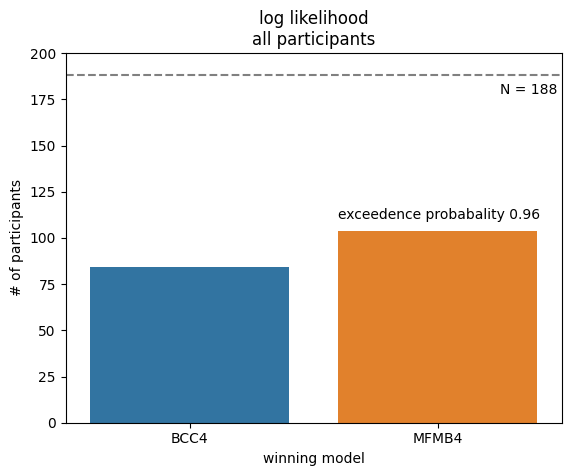

In [44]:
# plot model comparisons


plt.figure()
winning_model = BCC4_MFMB4_total_log_likes.argmin(dim=-1)
print((winning_model==0).sum().numpy())
plot_df = pd.DataFrame({"winning model": ["BCC4", "MFMB4"], 
                        "# of participants": torch.stack([(winning_model==0).sum(), (winning_model==1).sum()])})
print(plot_df)
sns.barplot(data=plot_df, y="# of participants", x="winning model")
plt.axhline(y=n_agents, color='grey', linestyle='--')
plt.text(1.25, 178, f"N = {n_agents}")
plt.text(0.6, 110, f"exceedence probabality {BCC4_MFMB4_log_likes_exc_prob:.2f}")
plt.ylim([0,200])
plt.title("log likelihood\nall participants")
plt.show()

110
  winning model  # of participants
0          BCC4                110
1         MFMB4                 78


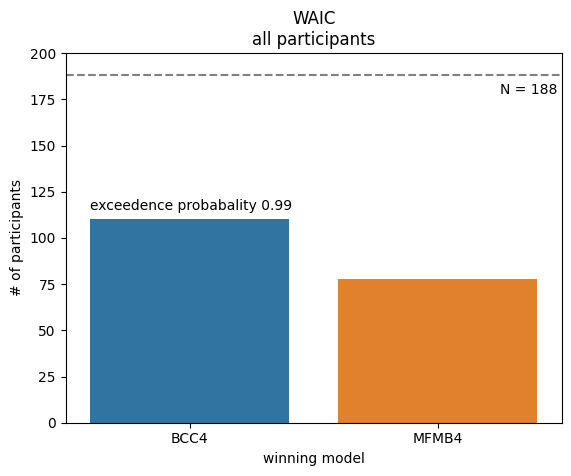

In [45]:
# plot model comparisons


plt.figure()
winning_model = BCC4_MFMB4_total_WAICs.argmin(dim=-1)
print((winning_model==0).sum().numpy())
plot_df = pd.DataFrame({"winning model": ["BCC4", "MFMB4"], 
                        "# of participants": torch.stack([(winning_model==0).sum(), (winning_model==1).sum()])})
print(plot_df)
sns.barplot(data=plot_df, y="# of participants", x="winning model")
plt.axhline(y=n_agents, color='grey', linestyle='--')
plt.text(1.25, 178, f"N = {n_agents}")
plt.text(-0.4, 115, f"exceedence probabality {BCC4_MFMB4_WAICs_exc_prob:.2f}")
plt.ylim([0,200])
plt.title("WAIC\nall participants")
plt.show()

65
  winning model  # of participants
0          BCC4                 65
1         MFMB4                100


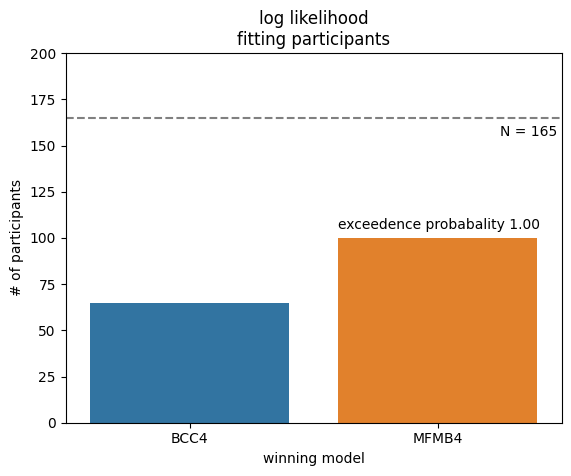

In [46]:
# plot model comparisons


plt.figure()
winning_model = BCC4_MFMB4_total_log_likes_did_fit.argmin(dim=-1)
print((winning_model==0).sum().numpy())
plot_df = pd.DataFrame({"winning model": ["BCC4", "MFMB4"], 
                        "# of participants": torch.stack([(winning_model==0).sum(), (winning_model==1).sum()])})
print(plot_df)
sns.barplot(data=plot_df, y="# of participants", x="winning model")
plt.axhline(y=did_fit.sum(), color='grey', linestyle='--')
plt.text(1.25, did_fit.sum()-10, f"N = {did_fit.sum()}")
plt.text(0.6, 105, f"exceedence probabality {BCC4_MFMB4_log_likes_exc_prob_did_fit:.2f}")
plt.ylim([0,200])
plt.title("log likelihood\nfitting participants")
plt.show()

88
  winning model  # of participants
0          BCC4                 88
1         MFMB4                 77


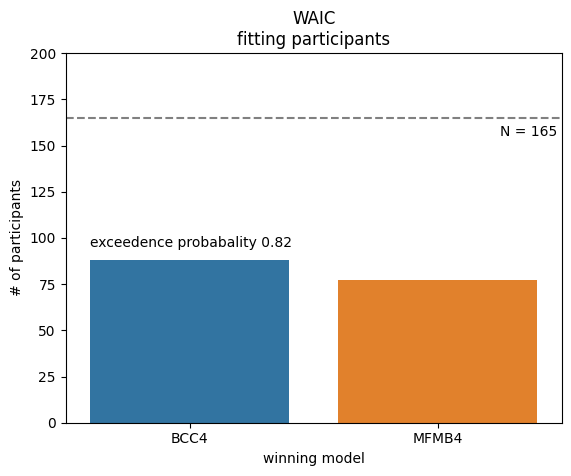

In [47]:
# plot model comparisons


plt.figure()
winning_model = BCC4_MFMB4_total_WAICs_did_fit.argmin(dim=-1)
print((winning_model==0).sum().numpy())
plot_df = pd.DataFrame({"winning model": ["BCC4", "MFMB4"], 
                        "# of participants": torch.stack([(winning_model==0).sum(), (winning_model==1).sum()])})
print(plot_df)
sns.barplot(data=plot_df, y="# of participants", x="winning model")
plt.axhline(y=did_fit.sum(), color='grey', linestyle='--')
plt.text(1.25, did_fit.sum()-10, f"N = {did_fit.sum()}")
plt.text(-0.4, 95, f"exceedence probabality {BCC4_MFMB4_WAICs_exc_prob_did_fit:.2f}")
plt.ylim([0,200])
plt.title("WAIC\nfitting participants")
plt.show()

96
  winning model  # of participants
0          BCC4                 96
1         MFMB4                 41
2         MFMB5                 51


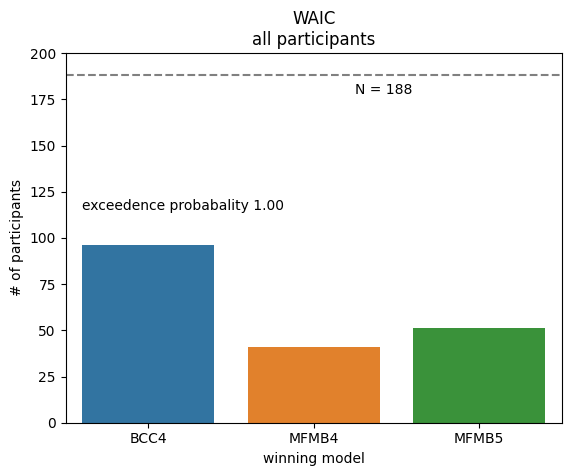

In [48]:
# plot model comparisons


plt.figure()
winning_model = BCC4_MFMB4_MFMB5_total_WAICs.argmin(dim=-1)
print((winning_model==0).sum().numpy())
plot_df = pd.DataFrame({"winning model": ["BCC4", "MFMB4", "MFMB5"], 
                        "# of participants": torch.stack([(winning_model==0).sum(), (winning_model==1).sum(), (winning_model==2).sum()])})
print(plot_df)
sns.barplot(data=plot_df, y="# of participants", x="winning model")
plt.axhline(y=n_agents, color='grey', linestyle='--')
plt.text(1.25, 178, f"N = {n_agents}")
plt.text(-0.4, 115, f"exceedence probabality {BCC4_MFMB4_MFMB5_WAICs_exc_prob:.2f}")
plt.ylim([0,200])
plt.title("WAIC\nall participants")
plt.show()

In [49]:
group_surely_BCC4 = torch.bitwise_and(BCC4_MFMB4_total_log_likes.argmin(dim=-1) == 0, BCC4_MFMB4_total_WAICs.argmin(dim=-1) == 0)
group_surely_MFMB4 = torch.bitwise_and(BCC4_MFMB4_total_log_likes.argmin(dim=-1) == 1, BCC4_MFMB4_total_WAICs.argmin(dim=-1) == 1)
group_log_MFMB4_WAIC_BCC4 = torch.bitwise_and(BCC4_MFMB4_total_log_likes.argmin(dim=-1) == 1, BCC4_MFMB4_total_WAICs.argmin(dim=-1) == 0)
group_log_BCC4_WAIC_MFMB4 = torch.bitwise_and(BCC4_MFMB4_total_log_likes.argmin(dim=-1) == 0, BCC4_MFMB4_total_WAICs.argmin(dim=-1) == 1)

print("all", BCC4_MFMB4_total_log_likes.shape[0], BCC4_MFMB4_total_WAICs.shape[0])
print("surely BCC4", group_surely_BCC4.sum())
print("surely MFMB4", group_surely_MFMB4.sum())
print("log MFMB4 waic BCC4", group_log_MFMB4_WAIC_BCC4.sum())
print("log BCC4 waic MFMB4", group_log_BCC4_WAIC_MFMB4.sum())

print("all", group_surely_BCC4.sum()+group_surely_MFMB4.sum()+group_log_MFMB4_WAIC_BCC4.sum()+group_log_BCC4_WAIC_MFMB4.sum())

all 188 188
surely BCC4 tensor(69)
surely MFMB4 tensor(63)
log MFMB4 waic BCC4 tensor(41)
log BCC4 waic MFMB4 tensor(15)
all tensor(188)


In [50]:
winning_model = []

for n in range(n_agents):
    if group_surely_BCC4[n]:
        winning_model.append("BCC4")
    elif group_surely_MFMB4[n]:
        winning_model.append("MFMB4")
    elif group_log_MFMB4_WAIC_BCC4[n]:
        winning_model.append("log MFMB4 WAIC BCC4")
    elif group_log_BCC4_WAIC_MFMB4[n]:
        winning_model.append("log BCC4 WAIC MFMB4")
print(winning_model)

['BCC4', 'MFMB4', 'BCC4', 'log MFMB4 WAIC BCC4', 'log MFMB4 WAIC BCC4', 'MFMB4', 'log MFMB4 WAIC BCC4', 'MFMB4', 'MFMB4', 'MFMB4', 'log MFMB4 WAIC BCC4', 'MFMB4', 'BCC4', 'MFMB4', 'log MFMB4 WAIC BCC4', 'log MFMB4 WAIC BCC4', 'log MFMB4 WAIC BCC4', 'log BCC4 WAIC MFMB4', 'MFMB4', 'log MFMB4 WAIC BCC4', 'BCC4', 'MFMB4', 'log MFMB4 WAIC BCC4', 'log MFMB4 WAIC BCC4', 'log MFMB4 WAIC BCC4', 'MFMB4', 'BCC4', 'MFMB4', 'BCC4', 'log MFMB4 WAIC BCC4', 'MFMB4', 'BCC4', 'log MFMB4 WAIC BCC4', 'BCC4', 'BCC4', 'log MFMB4 WAIC BCC4', 'BCC4', 'BCC4', 'log MFMB4 WAIC BCC4', 'MFMB4', 'MFMB4', 'BCC4', 'log MFMB4 WAIC BCC4', 'BCC4', 'BCC4', 'MFMB4', 'MFMB4', 'MFMB4', 'BCC4', 'MFMB4', 'log MFMB4 WAIC BCC4', 'BCC4', 'MFMB4', 'BCC4', 'BCC4', 'log MFMB4 WAIC BCC4', 'MFMB4', 'log MFMB4 WAIC BCC4', 'MFMB4', 'BCC4', 'MFMB4', 'MFMB4', 'BCC4', 'log MFMB4 WAIC BCC4', 'BCC4', 'MFMB4', 'MFMB4', 'MFMB4', 'MFMB4', 'log BCC4 WAIC MFMB4', 'MFMB4', 'log BCC4 WAIC MFMB4', 'BCC4', 'log MFMB4 WAIC BCC4', 'MFMB4', 'MFMB4', '

In [51]:
results_mean_df = pd.concat([BCC4_mean_df, MFMB4_mean_df, pd.DataFrame({"winning model": winning_model}), pd.DataFrame({"did fit": did_fit})], axis=1)

In [52]:
results_mean_df

,Unnamed: 0,inferred policy rate,subject,inferred reward rate,inferred dec temp,inferred habitual tendency,Unnamed: 0,inferred discount,subject,inferred learning rate,inferred mf weight,inferred mb weight,winning model,did fit
0,0,0.611855,0,0.163980,7.552092,0.859143,0,0.448627,0,0.497330,1.691471,1.964400,BCC4,True
1,1,0.485644,1,0.181525,7.495545,0.911870,1,0.560063,1,0.559505,2.351018,2.739979,MFMB4,True
2,2,0.459560,2,0.285278,2.278011,0.840181,2,0.321423,2,0.705197,0.845490,0.648211,BCC4,True
3,3,0.139927,3,0.039011,2.838758,0.894461,3,0.559565,3,0.197047,0.662403,0.505781,log MFMB4 WAIC BCC4,True
4,4,0.457440,4,0.369865,3.229622,0.904862,4,0.707715,4,0.499565,1.285887,0.953347,log MFMB4 WAIC BCC4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,183,0.579503,183,0.389000,1.342937,0.169818,183,0.203363,183,0.720747,0.580109,0.447950,BCC4,False
184,184,0.643951,184,0.296629,4.052590,0.921969,184,0.448108,184,0.654500,3.245775,2.275115,MFMB4,True
185,185,0.603069,185,0.273440,8.617109,0.880816,185,0.423943,185,0.624613,2.313950,4.092938,MFMB4,True
186,186,0.550328,186,0.242923,8.299362,0.818529,186,0.387136,186,0.563852,1.607338,2.730989,BCC4,True


In [61]:
def plot_group_bars(df, variable_of_interest, fontsize=12, only_fitting=True, annotate_pvals=False):
    model_names = ["BCC4", "MFMB4", "log MFMB4 WAIC BCC4", "log BCC4 WAIC MFMB4"]

    # test and annotate

    if only_fitting:
        working_df = df[df["did fit"]==True]
    else:
        working_df = df

    if annotate_pvals:
        vals = {}
        for name in model_names:
            vals[name] = working_df[working_df["winning model"]==name]["inferred "+variable_of_interest].values

        pairs = [("BCC4", "MFMB4"),
                ("BCC4", "log MFMB4 WAIC BCC4"),
                ("BCC4", "log BCC4 WAIC MFMB4"),
                ("MFMB4", "BCC4"),
                ("MFMB4", "log MFMB4 WAIC BCC4"),
                ("MFMB4", "log BCC4 WAIC MFMB4"),
                ("log MFMB4 WAIC BCC4", "BCC4"),
                ("log MFMB4 WAIC BCC4", "MFMB4"),
                ("log MFMB4 WAIC BCC4", "log BCC4 WAIC MFMB4"),
                ("log BCC4 WAIC MFMB4", "BCC4"),
                ("log BCC4 WAIC MFMB4", "MFMB4"),
                ("log BCC4 WAIC MFMB4", "log MFMB4 WAIC BCC4"),
                ]

        stat_results = [mannwhitneyu(vals[pair[0]], vals[pair[1]], alternative="two-sided") for pair in pairs]
        
        pvalues = [result.pvalue for result in stat_results]

        sig_pairs = []
        sig_pvalues = []
        for i,pair in enumerate(pairs):
            if pvalues[i] <= 0.05:
                sig_pairs.append(pair)
                sig_pvalues.append(pvalues[i])


    # plot
    plt.figure()
    g = sns.barplot(data=working_df, x="winning model", y="inferred "+variable_of_interest)
    g.set_xticklabels(model_names, rotation=30, fontsize=fontsize, horizontalalignment='right')
    plt.yticks(fontsize = fontsize)
    g.set_xlabel(g.get_xlabel(), fontsize=fontsize)
    g.set_ylabel(g.get_ylabel(), fontsize=fontsize)

    if annotate_pvals:
        ax = plt.gca()

        annotator = Annotator(ax, sig_pairs, data=working_df, x="winning model", y="inferred "+variable_of_interest)#, loc="outside")#, perform_stat_test=True)
        #annotator.configure(test="Mann-Whitney", comparisons_correction="bonferroni")
        #_, corrected_results = annotator.apply_and_annotate()
        annotator.set_pvalues(sig_pvalues)
        annotator.annotate()

    plt.show()

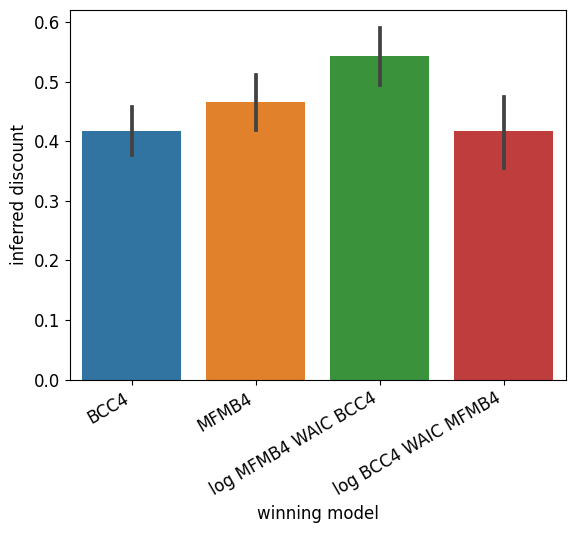

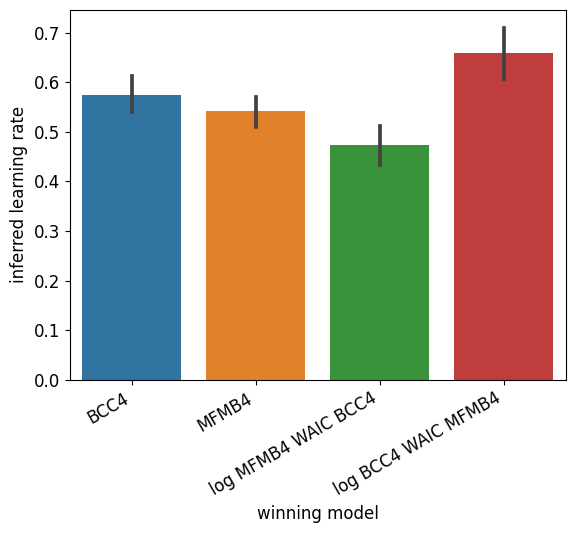

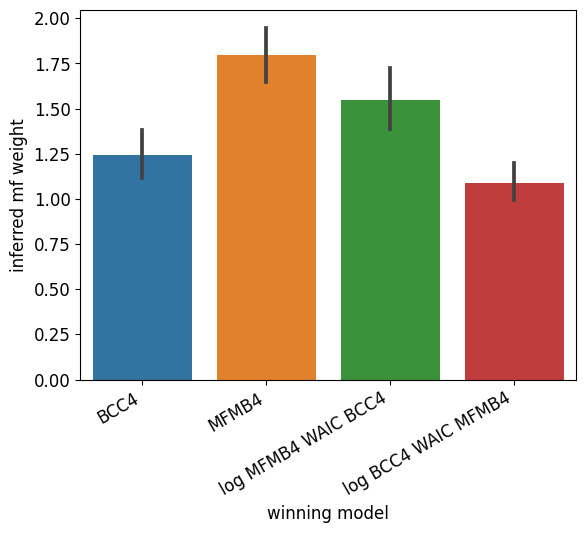

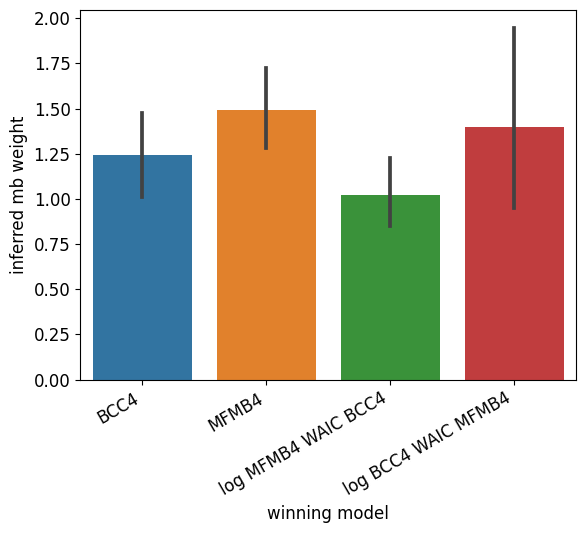

Ns tensor(50) tensor(62) tensor(38) tensor(15)


In [63]:
plot_fontsize = 12

for param in MFMB4_param_names:
    plot_group_bars(results_mean_df, param, only_fitting=True, annotate_pvals=False)

print("Ns", group_surely_BCC4[did_fit].sum(), group_surely_MFMB4[did_fit].sum(), group_log_MFMB4_WAIC_BCC4[did_fit].sum(), group_log_BCC4_WAIC_MFMB4[did_fit].sum())

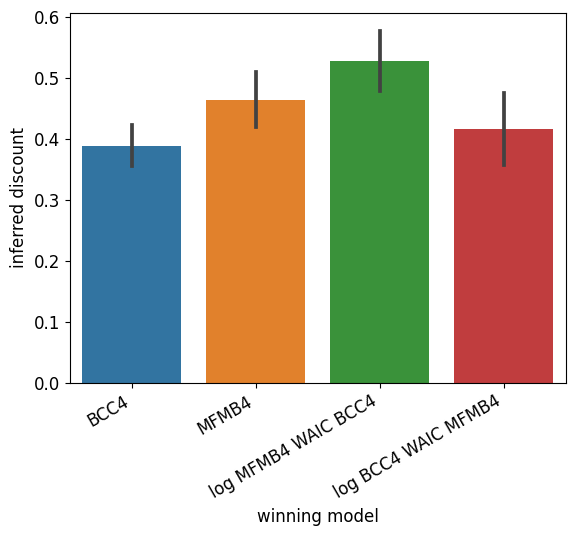

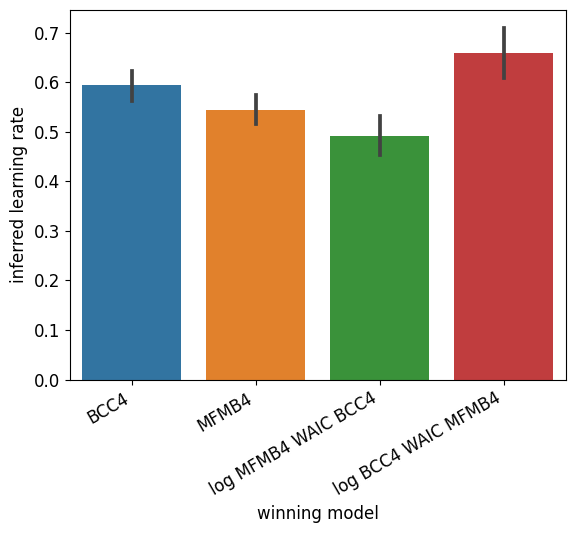

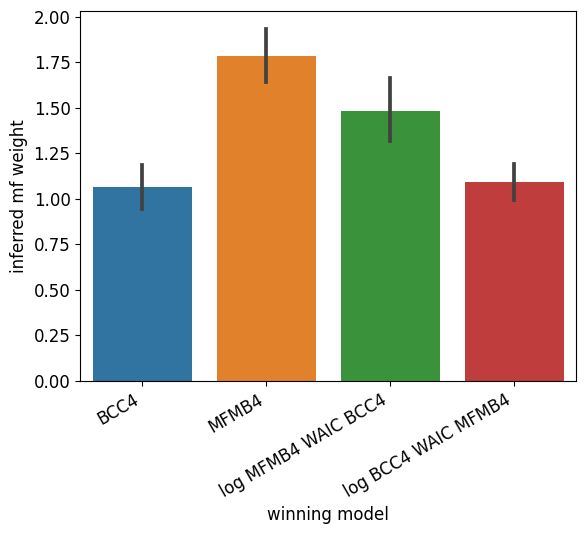

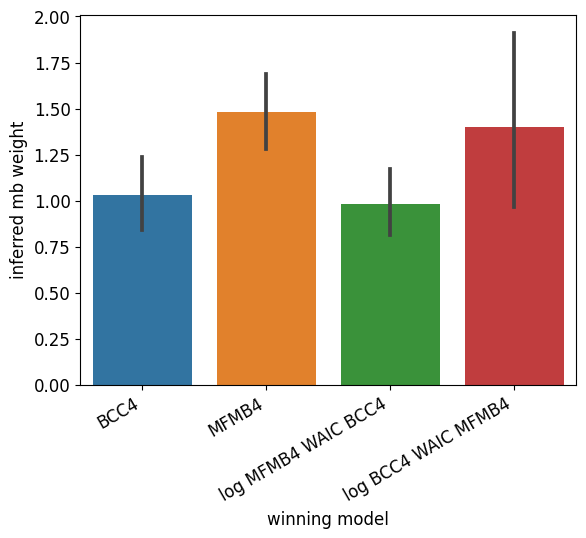

Ns tensor(69) tensor(63) tensor(41) tensor(15)


In [64]:
for param in MFMB4_param_names:
    plot_group_bars(results_mean_df, param, only_fitting=False)

print("Ns", group_surely_BCC4.sum(), group_surely_MFMB4.sum(), group_log_MFMB4_WAIC_BCC4.sum(), group_log_BCC4_WAIC_MFMB4.sum())

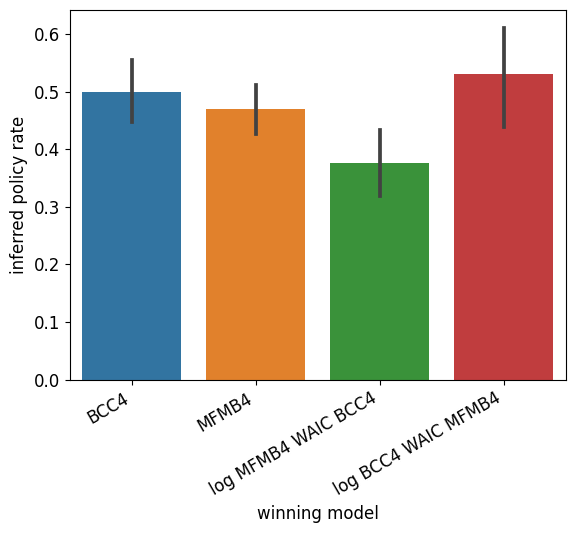

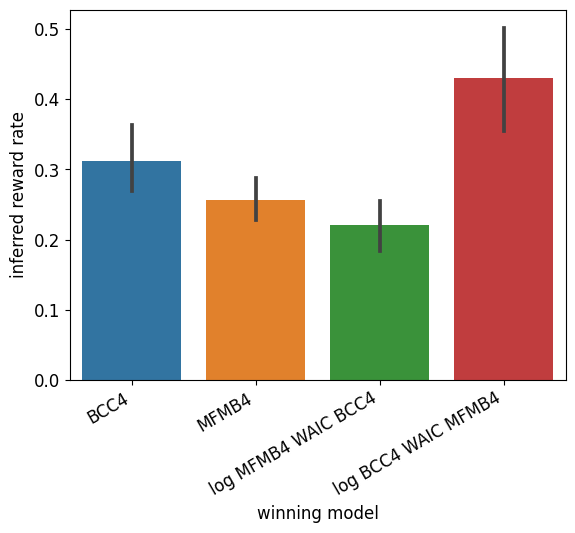

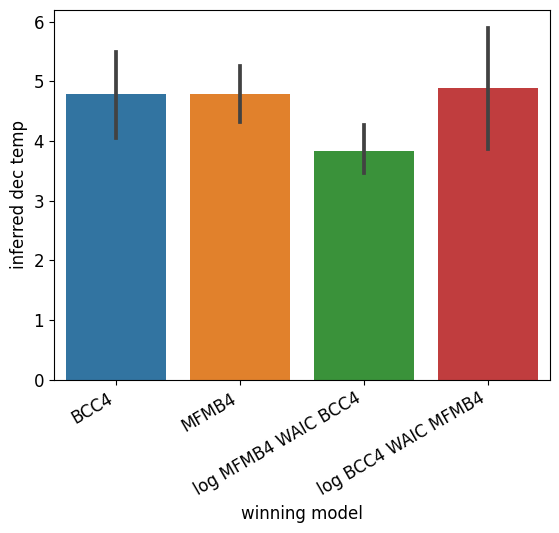

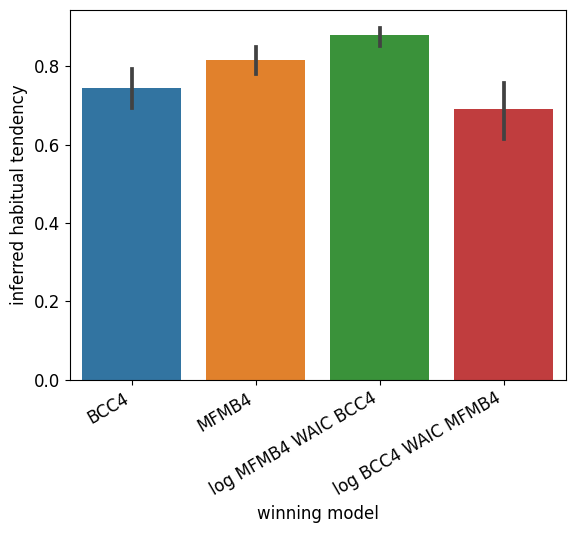

Ns tensor(50) tensor(62) tensor(38) tensor(15)


In [65]:
for param in BCC4_param_names:
    plot_group_bars(results_mean_df, param, only_fitting=True)

print("Ns", group_surely_BCC4[did_fit].sum(), group_surely_MFMB4[did_fit].sum(), group_log_MFMB4_WAIC_BCC4[did_fit].sum(), group_log_BCC4_WAIC_MFMB4[did_fit].sum())

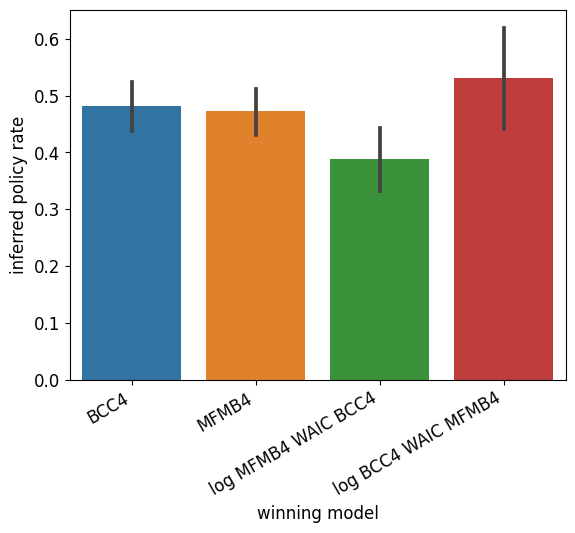

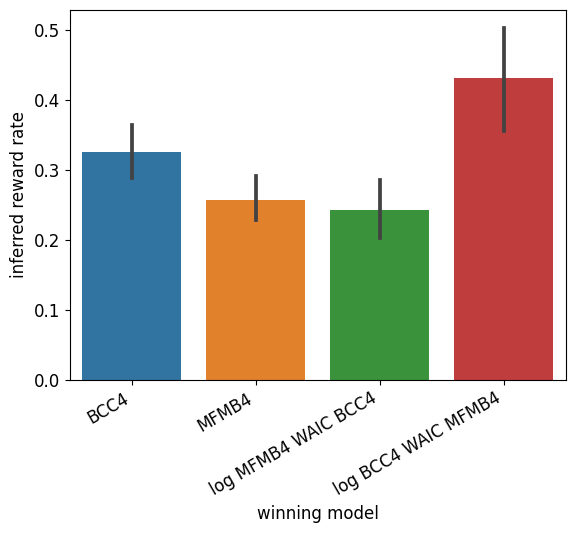

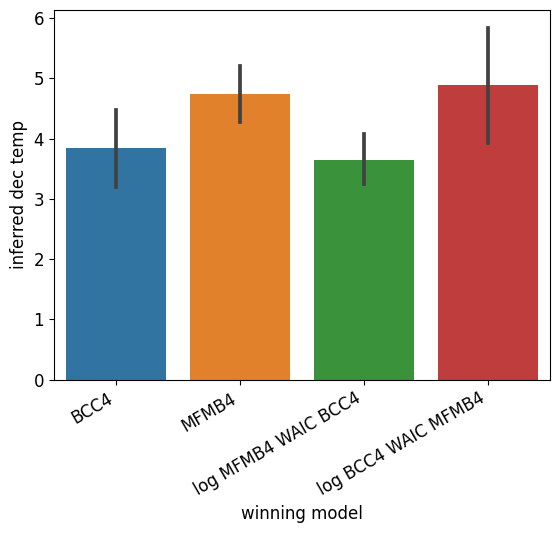

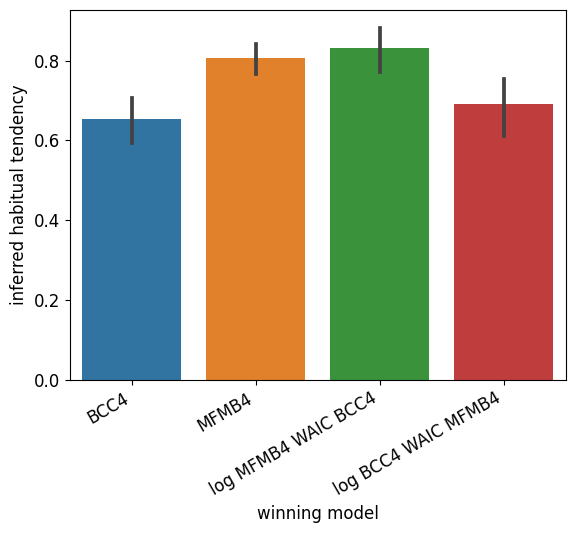

Ns tensor(69) tensor(63) tensor(41) tensor(15)


In [66]:
for param in BCC4_param_names:
    plot_group_bars(results_mean_df, param, only_fitting=False, fontsize=plot_fontsize)

print("Ns", group_surely_BCC4.sum(), group_surely_MFMB4.sum(), group_log_MFMB4_WAIC_BCC4.sum(), group_log_BCC4_WAIC_MFMB4.sum())